In [1]:
# Импорт библиотек
import os
import time

import GTU
import KU_TU
import mat_properties as prop
import numpy as n
import pandas as pd
import SP
from scipy.optimize import root

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel("streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)

# Состав газов в номинале
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = (
    gas_streams0.at["GTU-PEVD", "N2"],
    gas_streams0.at["GTU-PEVD", "O2"],
    gas_streams0.at["GTU-PEVD", "CO2"],
    gas_streams0.at["GTU-PEVD", "H2O"],
    gas_streams0.at["GTU-PEVD", "Ar"],
)

gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure = gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies

############################################################
# Расчет ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")
Gas_turbine_res = Gas_turbine.calc()
electric.at["GTU", "N"] = Gas_turbine_res["N"]
electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.at["DK", "N"] = Gas_turbine_res["Ndk"]
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.at["GTU-KU", "P"] = 0.1
gas_streams.at["GTU-KU", "H"] = gas0.p_t(
    gas_streams.at["GTU-KU", "P"], gas_streams.at["GTU-KU", "T"]
)["h"]
Gas_turbine_composition = pd.read_excel(
    "input.xlsx", sheet_name="Gas_composition0", index_col=0
)

# Параметры газа на выходе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.loc["GTU-PEVD", "N2":"Ar"] = Gas_turbine_composition.loc[
    "Fraction", "N2":"Ar"
]

############################################################
# Теплосеть
gas_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
water_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
Tnv = gas_streams.at["AIR", "T"]
water_streams.at["SWIN-TURB", "T"] = SP.Tset(Tnv)[1]
water_streams.at["SP2-WOUT", "T"] = SP.Tset(Tnv)[0]
# print(water_streams)
############################################################

# Состав газов при частичной нагрузке
fractiongas = (
    gas_streams.at["GTU-PEVD", "N2"],
    gas_streams.at["GTU-PEVD", "O2"],
    gas_streams.at["GTU-PEVD", "CO2"],
    gas_streams.at["GTU-PEVD", "H2O"],
    gas_streams.at["GTU-PEVD", "Ar"],
)
gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Основные константы
Calcmethod = "hybr"
KPD_PN = 0.8074
KPD_KN = 0.75
KPD_to = 0.99
KPD_SP = 0.99

Calctolerance = 10**-2
Teplo = 0
Maxiterations_KU_TU = 20
Maxiterations_cotel = 4
Maxiterations_turbine = 30
steamVD_fraction_to_turbine=0.3
# Class KU+TU
KU_and_TU = KU_TU.ku_tu(
    gas0,
    gas1,
    water,
    gas_streams0,
    gas_streams,
    water_streams0,
    water_streams,
    heaters,
    electric,
    "PEVD-DROSVD",
    "PPND-DROSND",
    "DROSVD-TURBVD",
    "DROSND-TURBND",
    steamVD_fraction_to_turbine,
    Calcmethod,
    KPD_SP,
    KPD_KN,
    KPD_to,
    KPD_PN,
)

start_time = time.time()

KU_and_TU.calculate(
    Teplo,
    Calctolerance,
    Maxiterations_KU_TU,
    Maxiterations_cotel,
    Maxiterations_turbine,
)

print(
    "Степень сухости пара в ЭВД: ",
    water.p_h(water_streams.at["EVD-IVD", "P"], water_streams.at["EVD-IVD", "H"])["Q"],
)
print(
    "Степень сухости пара в ГПК: ",
    water.p_h(water_streams.at["GPK-IND", "P"], water_streams.at["GPK-IND", "H"])["Q"],
)

print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")

Достигнуто максимальное количество итераций контура высокого давления
Fin котел-утилизатора:--- 6.0 сек. ---
dQ/Qsumm -0.0014415661006680818
Fin турбоустановка:--- 0.09 сек. ---
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура низкого давления
Повышена точность расчета котла для увеличения сходимости
dQ/Q ПЕВД+ИВД+ЭВД 2.7927907104463063
dQ/Q ПЕВД+ИВД+ЭВД -1.6003302727510726
dQ/Q ПЕВД+ИВД+ЭВД 0.7809102910902493
dQ/Q ПЕВД+ИВД+ЭВД -0.3869812296732026
Достигнуто максимальное количество итераций контура высокого давления
dQ/Q ППНД+ИНД+ГПК 0.26373976598912874
dQ/Q ППНД+ИНД+ГПК -0.04529849738427306
Достигнуто максимальное количество итераций котла-утилизатора
Fin турбоустановка:--- 0.07 сек. ---
Достигнуто максимальное количество итераций контура высокого давления
Fin котел-утилизатора:--- 5.24 сек. ---
dQ/Qsumm -0.014950061173943428
Fin турбоустановка:-

In [2]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,15.000000,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
REF-SMESH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-PEVD,542.010558,0.1,958.533980,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,463.381551,0.1,868.746159,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,268.102723,0.1,652.778404,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,202.191242,0.1,581.999894,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,199.983868,0.1,579.645508,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,149.657477,0.1,526.216885,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,90.114656,0.1,463.535430,503.497387,0.7803,0.1237,0.0301,0.0594,0.0065


In [3]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,517.407131,3.822149,3487.710550,64.865470,NaN,NaN
IVD-PEVD,258.122071,4.550809,2797.604118,64.865470,NaN,NaN
EVD-IVD,258.122071,4.550809,1138.286611,64.865470,NaN,NaN
PEN-EVD,140.586357,4.550809,594.388669,64.865470,NaN,NaN
BND-PEN,139.913630,0.360656,588.791239,64.865470,NaN,NaN
PPND-DROSND,186.138780,0.354448,2834.277026,11.614837,NaN,NaN
IND-PPND,139.913630,0.360656,2733.331207,11.614837,NaN,NaN
GPK-IND,134.630095,0.360656,566.196370,76.480307,NaN,NaN
GPK-REC,134.630095,0.360656,566.196370,99.273533,NaN,NaN


In [4]:
Errors_water = abs(water_streams - water_streams0) / water_streams0 * 100
Errors_gas = abs(gas_streams - gas_streams0) / gas_streams0 * 100
Errors_gas
Errors_water

,G,H,P,S,T,X
AIR,NaN,NaN,NaN,NaN,0.000000,NaN
PEVD-DROSVD,2.311466,1.884213,54.536110,NaN,1.154864,NaN
IVD-PEVD,2.311466,1.838303,47.966971,NaN,14.329849,NaN
EVD-IVD,2.311466,14.922973,47.966971,NaN,13.613765,NaN
PEN-EVD,2.311466,16.084708,47.966971,NaN,15.563750,NaN
BND-PEN,2.311466,15.415172,48.211306,NaN,15.069187,NaN
PPND-DROSND,21.308692,1.295666,48.705068,NaN,12.032713,NaN
IND-PPND,21.308692,1.057137,48.211306,NaN,15.069187,NaN
GPK-IND,2.149044,18.590726,48.211306,NaN,18.207719,NaN
GPK-REC,19.736501,18.590726,48.211306,NaN,18.207719,NaN


In [5]:
gas_streams0

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
REF-SMESH,NaN,NaN,-9999.990000,NaN,NaN,NaN,NaN,NaN,NaN
GTU-PEVD,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,468.05,0.1,874.031830,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.20,0.1,697.417326,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.90,0.1,618.078812,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,233.00,0.1,614.965387,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.50,0.1,553.594555,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,106.90,0.1,481.155410,503.8,0.7803,0.1237,0.0301,0.0594,0.0065


In [6]:
electric

,Ni,N,KPDm,KPD
PEN,0.363080,0.461303,0.787075,0.807400
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,150.750600,NaN,33.348086
DK,NaN,6.269747,NaN,NaN
Turbine,25.466612,NaN,NaN,NaN
Tots1,10.854178,NaN,NaN,0.844250
Tots2,4.082963,NaN,NaN,0.837118
Tots3,8.167096,NaN,NaN,0.814963
Tots4,2.362375,NaN,NaN,0.776834


In [7]:
heaters

,Qw,Qg,KPD
PEVD,44755.854323,45207.933659,0.99
IVD,107651.808270,108739.200273,0.99
EVD,35280.426741,35636.794688,0.99
PPND,1173.572886,1185.427158,0.99
IND,26632.160518,26901.172241,0.99
GPK,31244.349149,31559.948636,0.99
SP2,NaN,NaN,NaN
SP1,NaN,NaN,NaN
OD,NaN,NaN,NaN
ASW,NaN,NaN,NaN


In [8]:
GTU_input

,1,2,3,4,5,6
tair,15,NaN,NaN,NaN,NaN,NaN
n,1,NaN,NaN,NaN,NaN,NaN
Pin,0,NaN,NaN,NaN,NaN,NaN
Pout,0,NaN,NaN,NaN,NaN,NaN


,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,517.407131,3.822149,3487.710550,64.865470,7.165890,NaN
IVD-PEVD,258.122071,4.550809,2797.604118,64.865470,NaN,NaN
EVD-IVD,258.122071,4.550809,1138.286611,64.865470,NaN,NaN
PEN-EVD,140.586357,4.550809,594.388669,64.865470,NaN,NaN
BND-PEN,139.913630,0.360656,588.791239,64.865470,NaN,NaN
PPND-DROSND,186.138780,0.354448,2834.277026,11.614837,7.169747,NaN
IND-PPND,139.913630,0.360656,2733.331207,11.614837,NaN,NaN
GPK-IND,134.630095,0.360656,566.196370,76.480307,NaN,NaN
GPK-REC,134.630095,0.360656,566.196370,99.273533,NaN,NaN


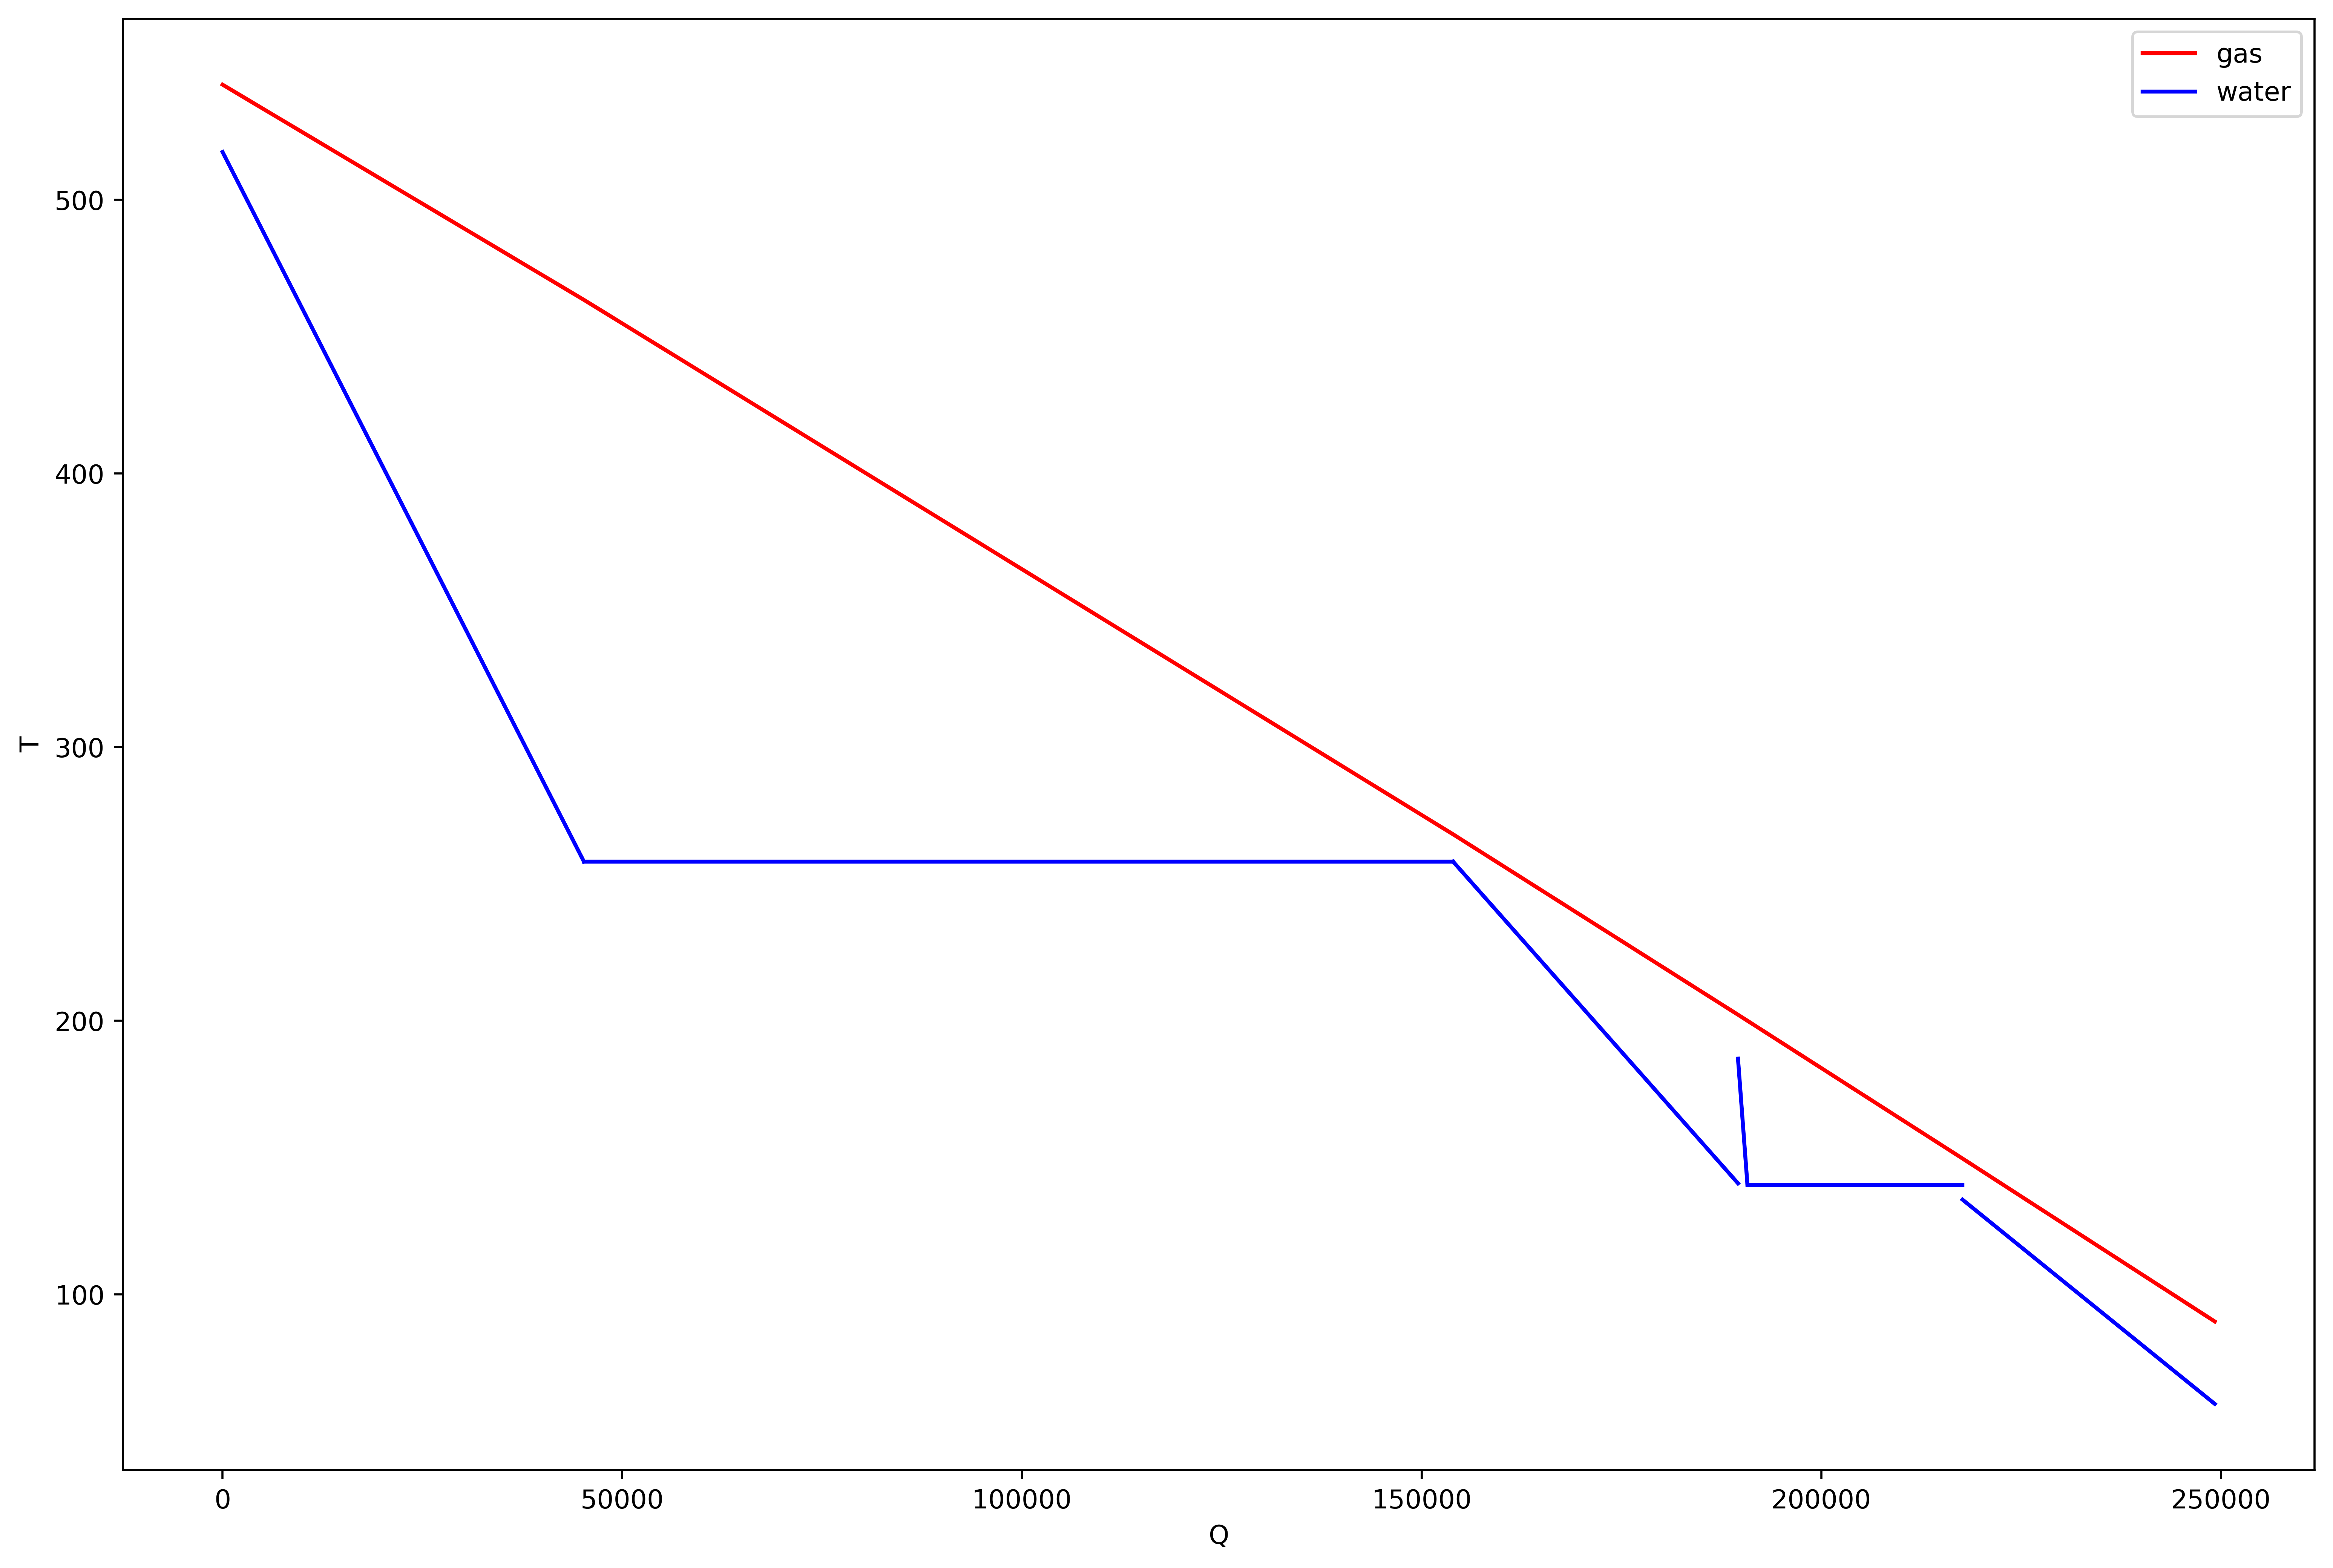

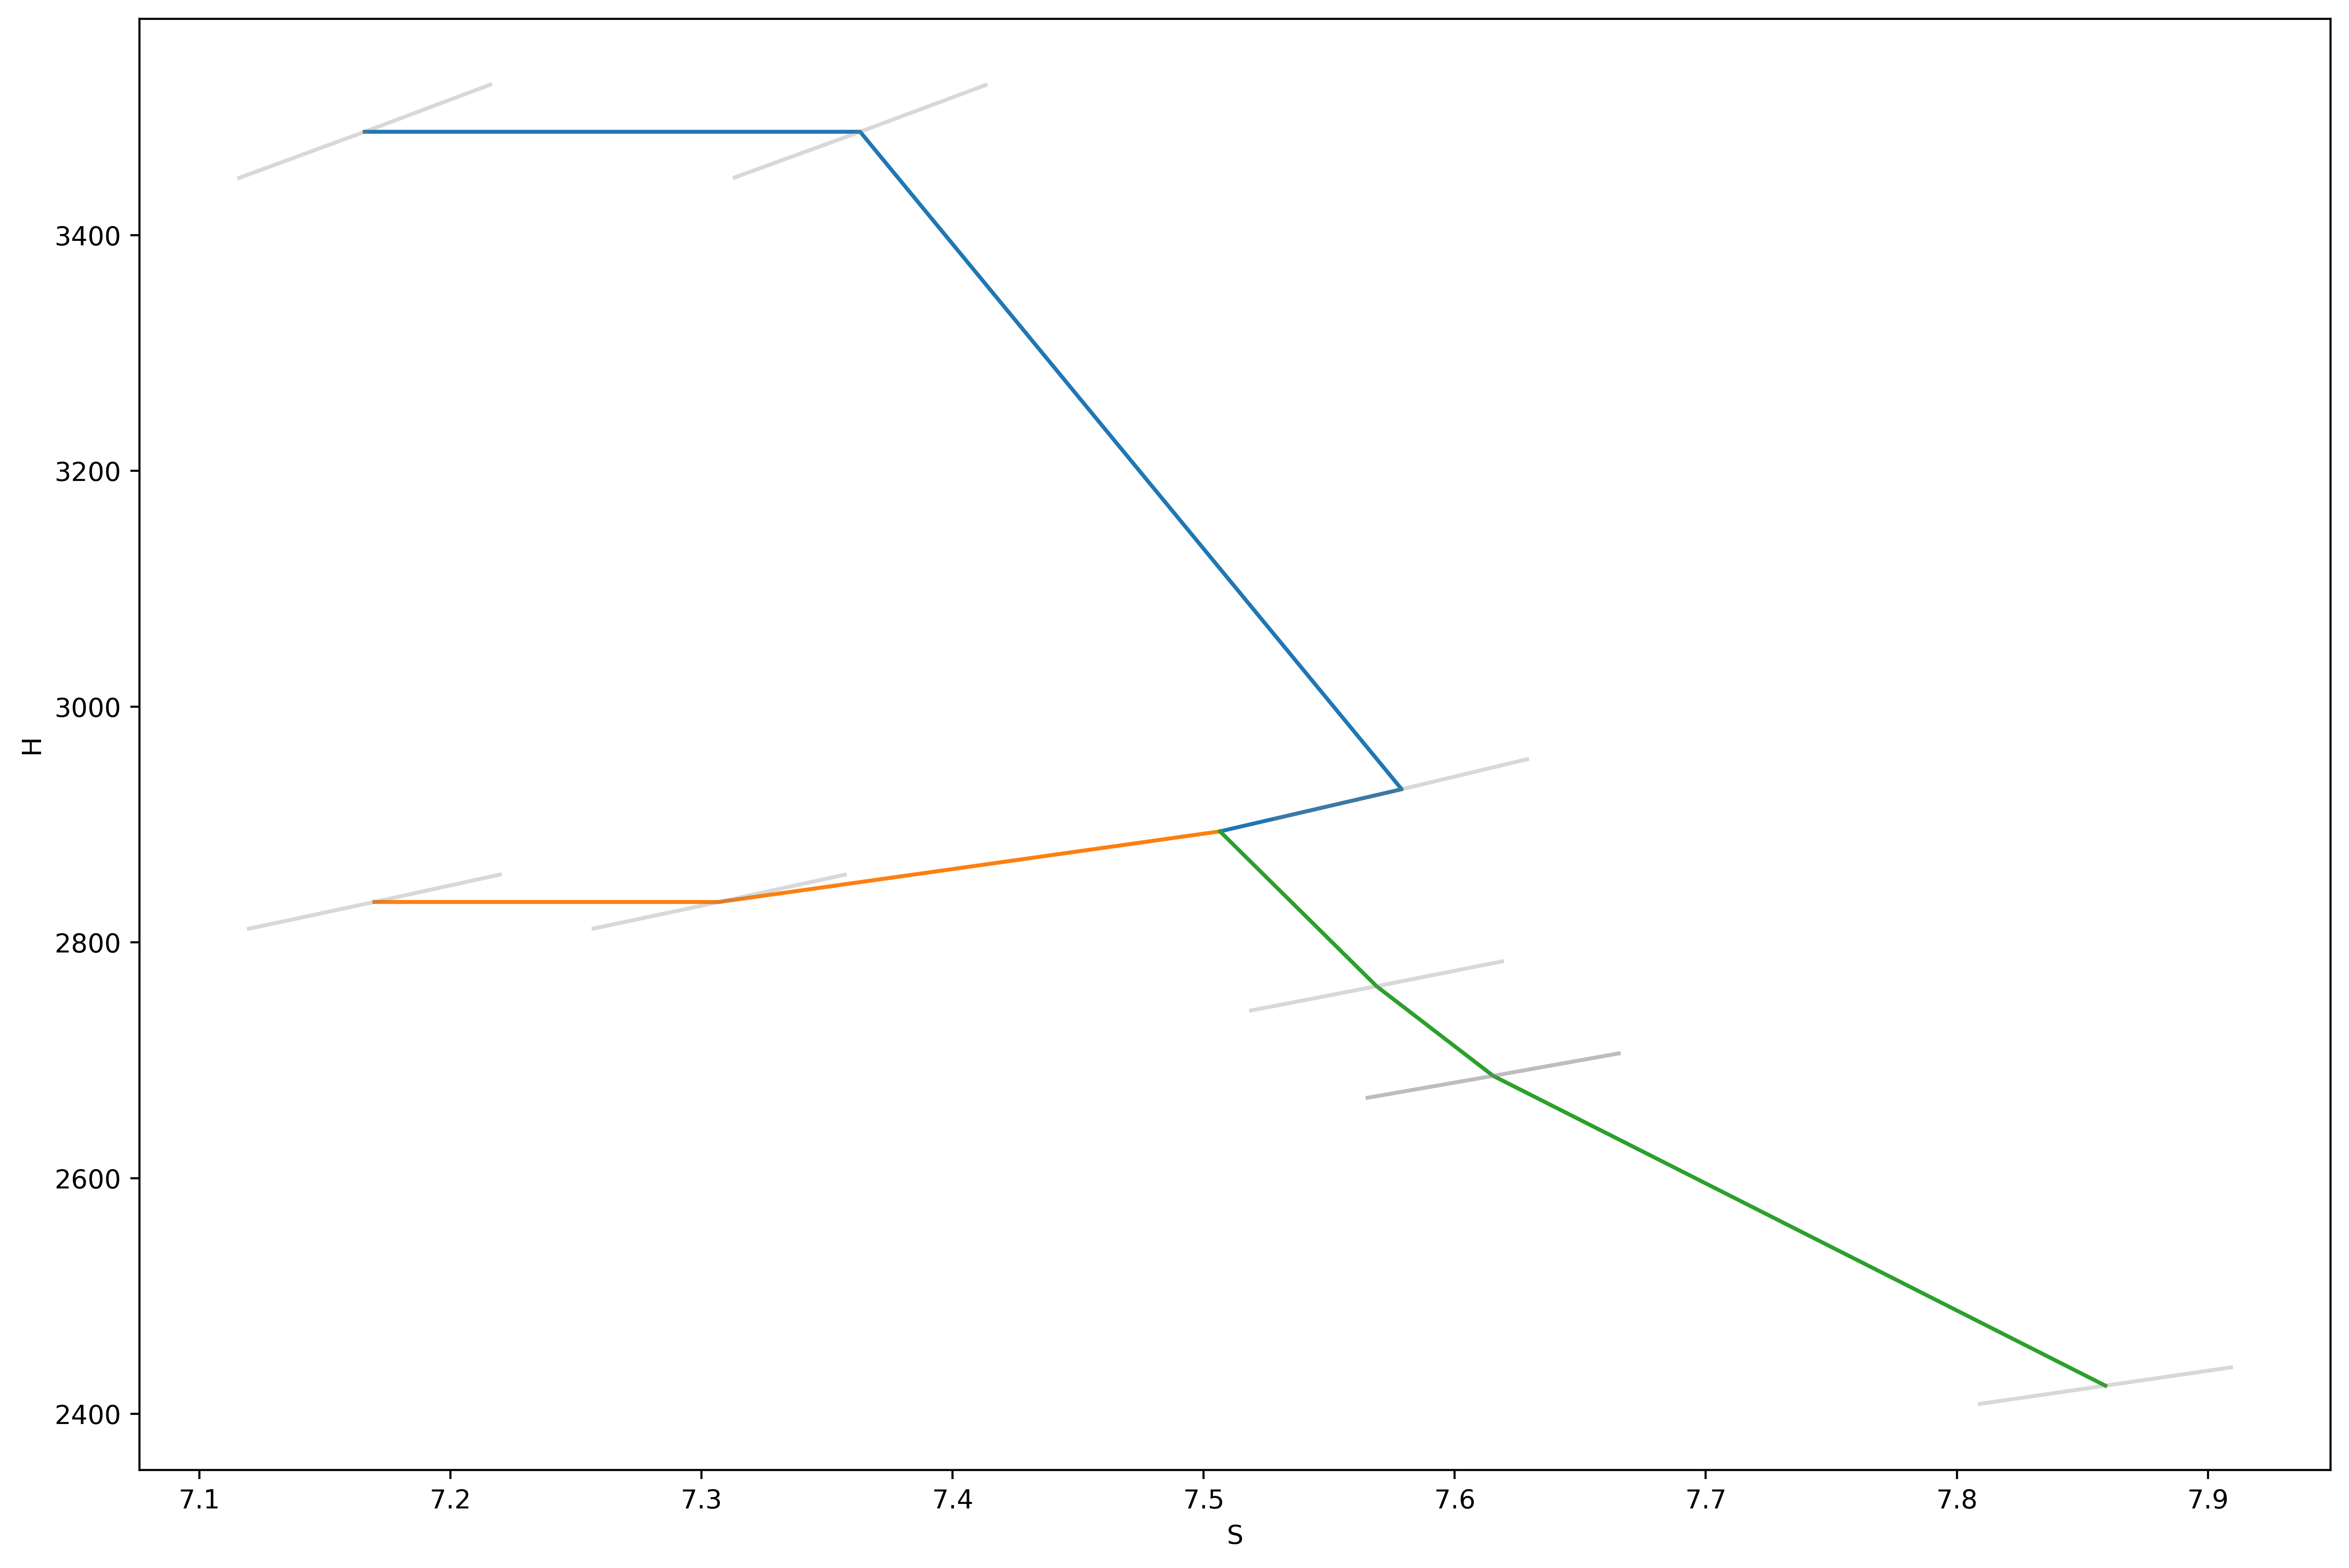

In [9]:
import Grafiki

Grafiki.Q_t_diagram(gas_streams, water_streams, heaters, 15, 10)
Grafiki.H_S_diagram(water, water_streams, 15, 10)
water_streams

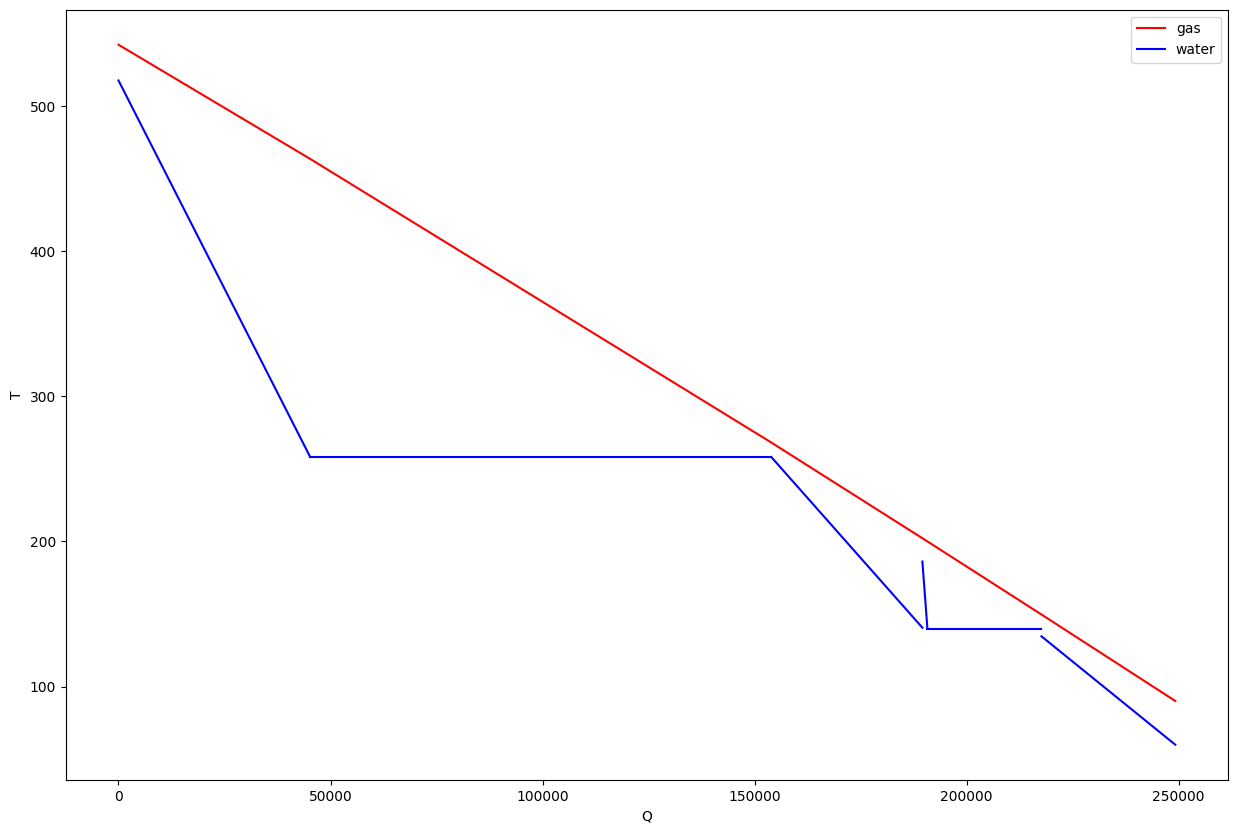

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
Qg = [
    0,
    heaters.loc["PEVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"] + heaters.loc["EVD", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"]
    + heaters.loc["GPK", "Qg"],
]
Qw = [
    0,
    heaters.loc["PEVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"] + heaters.loc["EVD", "Qg"],
    heaters.loc["PEVD", "Qg"] + heaters.loc["IVD", "Qg"] + heaters.loc["EVD", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"],
    heaters.loc["PEVD", "Qg"]
    + heaters.loc["IVD", "Qg"]
    + heaters.loc["EVD", "Qg"]
    + heaters.loc["PPND", "Qg"]
    + heaters.loc["IND", "Qg"]
    + heaters.loc["GPK", "Qg"],
]
Tg = gas_streams.loc["GTU-PEVD":"GPK-out", "T"]
Tw = [
    water_streams.loc["PEVD-DROSVD", "T"],
    water_streams.loc["IVD-PEVD", "T"],
    water_streams.loc["IVD-PEVD", "T"],
    water_streams.loc["EVD-IVD", "T"],
    water_streams.loc["PEN-EVD", "T"],
    water_streams.loc["PPND-DROSND", "T"],
    water_streams.loc["IND-PPND", "T"],
    water_streams.loc["IND-PPND", "T"],
    water_streams.loc["GPK-REC", "T"],
    water_streams.loc["REC-GPK", "T"],
]
plt.plot(Qg, Tg, color="red")
plt.plot(Qw[0:2], Tw[0:2], color="blue")
plt.plot(Qw[1:3], Tw[1:3], color="blue")
plt.plot(Qw[3:5], Tw[3:5], color="blue")
plt.plot(Qw[5:7], Tw[5:7], color="blue")
plt.plot(Qw[6:8], Tw[6:8], color="blue")
plt.plot(Qw[8:10], Tw[8:10], color="blue")
plt.xlabel("Q")
plt.ylabel("T")
plt.legend(["gas", "water"])
plt.show()

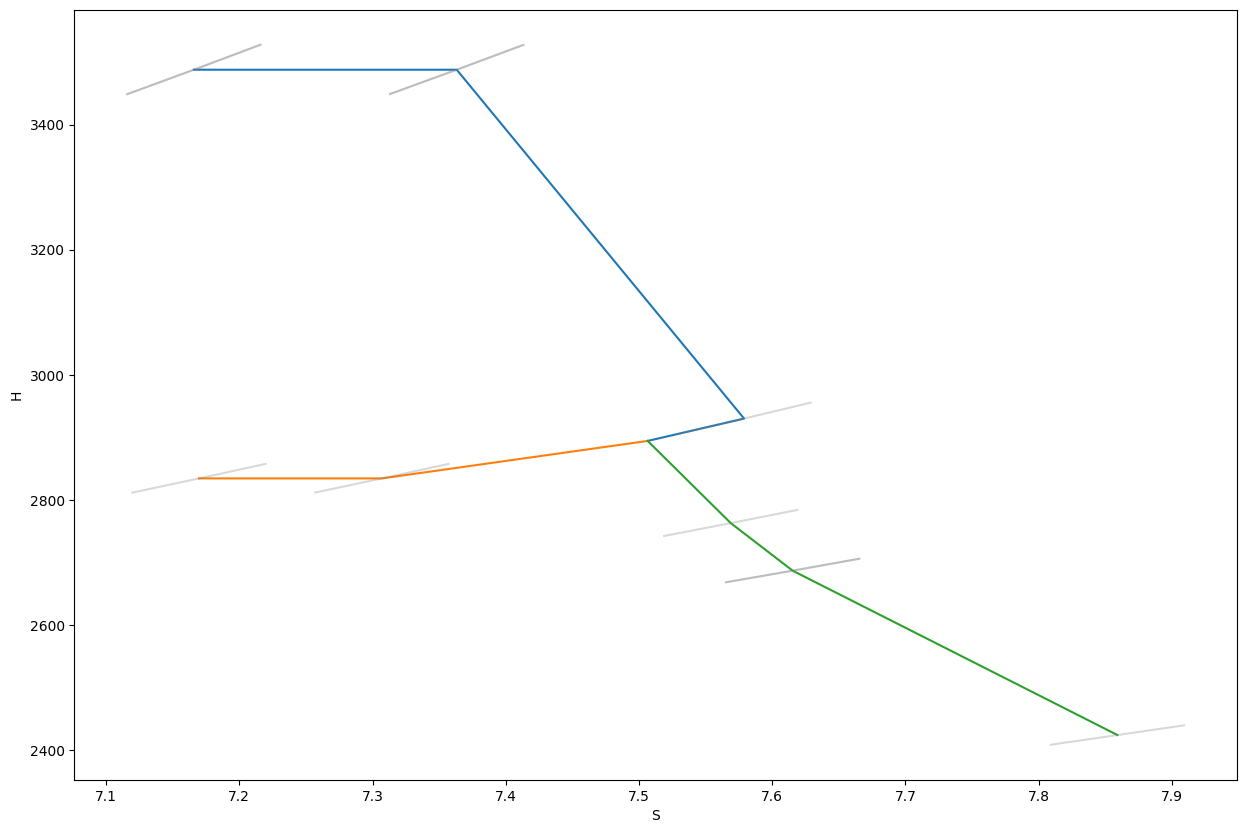

,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,517.407131,3.822149,3487.710550,64.865470,7.165890,NaN
IVD-PEVD,258.122071,4.550809,2797.604118,64.865470,NaN,NaN
EVD-IVD,258.122071,4.550809,1138.286611,64.865470,NaN,NaN
PEN-EVD,140.586357,4.550809,594.388669,64.865470,NaN,NaN
BND-PEN,139.913630,0.360656,588.791239,64.865470,NaN,NaN
PPND-DROSND,186.138780,0.354448,2834.277026,11.614837,7.169747,NaN
IND-PPND,139.913630,0.360656,2733.331207,11.614837,NaN,NaN
GPK-IND,134.630095,0.360656,566.196370,76.480307,NaN,NaN
GPK-REC,134.630095,0.360656,566.196370,99.273533,NaN,NaN


In [11]:
import matplotlib.pyplot as plt

water_streams.at["PEVD-DROSVD", "S"] = water.p_h(
    water_streams.at["PEVD-DROSVD", "P"], water_streams.at["PEVD-DROSVD", "H"]
)["s"]
water_streams.at["PPND-DROSND", "S"] = water.p_h(
    water_streams.at["PPND-DROSND", "P"], water_streams.at["PPND-DROSND", "H"]
)["s"]

plt.figure(figsize=(15, 10))
Hvd = [
    water_streams.at["PEVD-DROSVD", "H"],
    water_streams.at["DROSVD-TURBVD", "H"],
    water_streams.at["ENDOFVD", "H"],
    water_streams.at["SMESHEND", "H"],
]
Svd = [
    water_streams.at["PEVD-DROSVD", "S"],
    water_streams.at["DROSVD-TURBVD", "S"],
    water_streams.at["ENDOFVD", "S"],
    water_streams.at["SMESHEND", "S"],
]
Hsm = [
    water_streams.at["PPND-DROSND", "H"],
    water_streams.at["DROSND-TURBND", "H"],
    water_streams.at["SMESHEND", "H"],
]
Ssm = [
    water_streams.at["PPND-DROSND", "S"],
    water_streams.at["DROSND-TURBND", "S"],
    water_streams.at["SMESHEND", "S"],
]
Hnd = [
    water_streams.at["SMESHEND", "H"],
    water_streams.at["DOOTB2", "H"],
    water_streams.at["DOOTB1", "H"],
    water_streams.at["INCND", "H"],
    water_streams.at["INKOND", "H"],
]
Snd = [
    water_streams.at["SMESHEND", "S"],
    water_streams.at["DOOTB2", "S"],
    water_streams.at["DOOTB1", "S"],
    water_streams.at["INCND", "S"],
    water_streams.at["INKOND", "S"],
]

# Давления
stream = "PEVD-DROSVD"
H1 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S1 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DROSVD-TURBVD"
H2 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S2 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "ENDOFVD"
H3 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S3 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "PEVD-DROSVD"
H4 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S4 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DROSVD-TURBVD"
H5 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S5 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "PPND-DROSND"
H6 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S6 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DROSND-TURBND"
H7 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S7 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]

stream = "DOOTB2"
H8 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S8 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "DOOTB1"
H9 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S9 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "INCND"
H10 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S10 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]
stream = "INKOND"
H11 = [
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] - 0.05)["h"],
    water_streams.at[stream, "H"],
    water.p_s(water_streams.at[stream, "P"], water_streams.at[stream, "S"] + 0.05)["h"],
]
S11 = [
    water_streams.at[stream, "S"] - 0.05,
    water_streams.at[stream, "S"],
    water_streams.at[stream, "S"] + 0.05,
]


plt.plot(Svd, Hvd)
plt.plot(Ssm, Hsm)
plt.plot(Snd, Hnd)
plt.plot(S1, H1,S2,H2,S3,H3,
    S4,
    H4,
    S5,
    H5,
    S6,
    H6,
    S7,
    H7,
    S8,
    H8,
    S9,
    H9,
    S10,
    H10,
    S11,
    H11,
    color="gray",
    alpha=0.3,
)
plt.xlabel("S")
plt.ylabel("H")
plt.show()
water_streams